# Predict if a student will graduate or drop out

Using this database: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success 

Text(0.5, 1.0, 'Dropout')

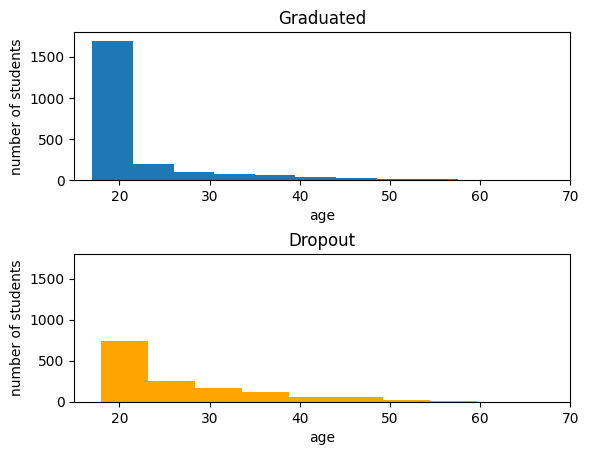

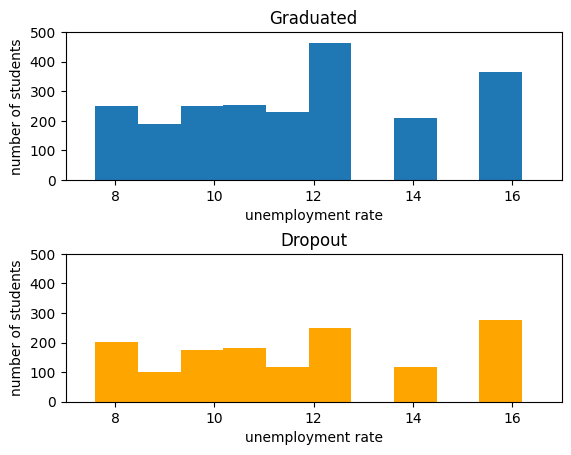

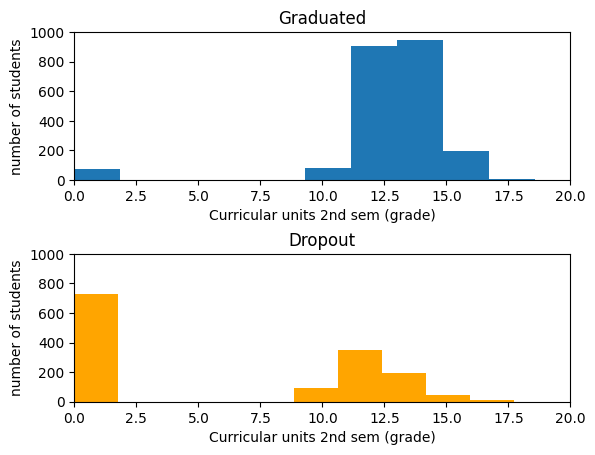

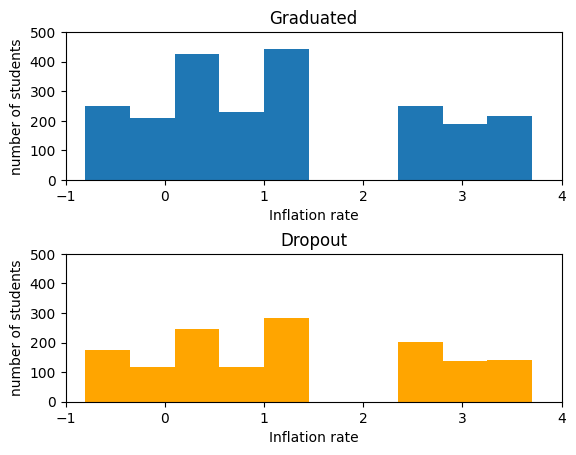

In [49]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# Load the data
data = pd.read_csv('data.csv', delimiter=';')

# Remove students who are only enrolled
data = data[data['Target'] != 'Enrolled']
data.columns = data.columns.str.rstrip()
data.head()

# Make separate tables for Graduates and Dropouts
dataGraduate = data[data['Target'] == 'Graduate']
dataDropout = data[data['Target'] == 'Dropout']

# PLOT SOME OF THE COLUMNS WE'LL BE USING

# Make a histogram based on age
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5) # Make a little extra space between the subplots

ax1.hist(dataGraduate['Age at enrollment'])
ax1.set_xlabel('age')
ax1.set_ylabel('number of students')
ax1.set_xlim(15, 70)
ax1.set_ylim(0, 1800)
ax1.set_title('Graduated')

ax2.hist(dataDropout['Age at enrollment'], color='orange')
ax2.set_xlabel('age')
ax2.set_ylabel('number of students')
ax2.set_xlim(15, 70)
ax2.set_ylim(0, 1800)
ax2.set_title('Dropout')

# Make a histogram based on Unemployment rate
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5) # Make a little extra space between the subplots

ax1.hist(dataGraduate['Unemployment rate'])
ax1.set_xlabel('unemployment rate')
ax1.set_ylabel('number of students')
ax1.set_xlim(7, 17)
ax1.set_ylim(0, 500)
ax1.set_title('Graduated')

ax2.hist(dataDropout['Unemployment rate'], color='orange')
ax2.set_xlabel('unemployment rate')
ax2.set_ylabel('number of students')
ax2.set_xlim(7, 17)
ax2.set_ylim(0, 500)
ax2.set_title('Dropout')

# Make a histogram based on Curricular units 2nd sem (grade)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5) # Make a little extra space between the subplots

ax1.hist(dataGraduate['Curricular units 2nd sem (grade)'])
ax1.set_xlabel('Curricular units 2nd sem (grade)')
ax1.set_ylabel('number of students')
ax1.set_xlim(0, 20)
ax1.set_ylim(0, 1000)
ax1.set_title('Graduated')

ax2.hist(dataDropout['Curricular units 2nd sem (grade)'], color='orange')
ax2.set_xlabel('Curricular units 2nd sem (grade)')
ax2.set_ylabel('number of students')
ax2.set_xlim(0, 20)
ax2.set_ylim(0, 1000)
ax2.set_title('Dropout')

# Make a histogram based on Inflation rate
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5) # Make a little extra space between the subplots

ax1.hist(dataGraduate['Inflation rate'])
ax1.set_xlabel('Inflation rate')
ax1.set_ylabel('number of students')
ax1.set_xlim(-1, 4)
ax1.set_ylim(0, 500)
ax1.set_title('Graduated')

ax2.hist(dataDropout['Inflation rate'], color='orange')
ax2.set_xlabel('Inflation rate')
ax2.set_ylabel('number of students')
ax2.set_xlim(-1, 4)
ax2.set_ylim(0, 500)
ax2.set_title('Dropout')



In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

k = 3
nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean', algorithm='auto')  # +1 to exclude the student themselves

# Standardize the features
data['Age at enrollment Standardized'] = (data['Age at enrollment'] - data['Age at enrollment'].mean()) / data['Age at enrollment'].std()
data['Previous qualification (grade) Standardized'] = (data['Previous qualification (grade)'] - data['Previous qualification (grade)'].mean()) / data['Previous qualification (grade)'].std()
data['Curricular units 2nd sem (grade) Standardized'] = (data['Curricular units 2nd sem (grade)'] - data['Curricular units 2nd sem (grade)'].mean()) / data['Curricular units 2nd sem (grade)'].std()
data['Unemployment rate Standardized'] = (data['Unemployment rate'] - data['Unemployment rate'].mean()) / data['Unemployment rate'].std()
data['Inflation rate Standardized'] = (data['Inflation rate'] - data['Inflation rate'].mean()) / data['Inflation rate'].std()
data['Curricular units 2nd sem (enrolled) Standardized'] = (data['Curricular units 2nd sem (enrolled)'] - data['Curricular units 2nd sem (enrolled)'].mean()) / data['Curricular units 2nd sem (enrolled)'].std()

# All Data
X = data[['Unemployment rate Standardized', 'Inflation rate Standardized', 'Curricular units 2nd sem (grade) Standardized', 'Age at enrollment Standardized', 'Curricular units 2nd sem (enrolled) Standardized', 'Previous qualification (grade) Standardized']].values

# Only national economic data
# X = data[['Unemployment rate Standardized', 'Inflation rate Standardized']].values

# Only student data
# X = data[['Curricular units 2nd sem (grade) Standardized', 'Age at enrollment Standardized', 'Curricular units 2nd sem (enrolled) Standardized', 'Previous qualification (grade) Standardized']].values

y = data['Target'].values

# Monte Carlo cross-validation parameters
n_iterations = 10
test_size = 0.25

precision_scores = []
recall_scores = []
f1_scores = []

for i in range(n_iterations):

    # Use random_state if you want the same values each time you run for debugging,
    # but you should select the split randomly when you're ready to actually train
    # and test on the data.

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) #, random_state=42)

    # Fit the model with the training data
    fit = nn.fit(X_train)

    # Find the k nearest neighbors for the test set
    distances, indices = fit.kneighbors(X_test)
    # print('Indices of k-nearest neighbors for each test sample:')
    # print(indices)

    y_pred = []
    for j in range(len(X_test)):
        # Exclude the student theirself by taking the next k neighbors
        nbrs = data.iloc[indices[j][1:]]
        # nbrs = data.ilocp[indices[i]]
        graduated = nbrs[nbrs.Target == 'Graduate'].count().Target
        dropout = nbrs[nbrs.Target == 'Dropout'].count().Target
        predict = 'Dropout' if (dropout > graduated) else 'Graduated'
        y_pred.append(predict)

    # Calculate precision, recall, and F1-score
    (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=['Dropout'])
    precision_scores.append(p[0])
    recall_scores.append(r[0])
    f1_scores.append(f[0])
    print(f"Iteration {i}: Precision: {p}, Recall: {r}, F1-Score: {f}, Support: {s}")

# Calculate the average precision, recall, and F1-score
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f"Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-Score: {avg_f1}")

Iteration 0: Precision: [0.41791045], Recall: [0.32748538], F1-Score: [0.36721311], Support: [342]
Iteration 1: Precision: [0.41868512], Recall: [0.33988764], F1-Score: [0.3751938], Support: [356]
Iteration 2: Precision: [0.36679537], Recall: [0.26536313], F1-Score: [0.30794165], Support: [358]
Iteration 3: Precision: [0.41946309], Recall: [0.35511364], F1-Score: [0.38461538], Support: [352]
Iteration 4: Precision: [0.39354839], Recall: [0.34463277], F1-Score: [0.36746988], Support: [354]
Iteration 5: Precision: [0.36690647], Recall: [0.28333333], F1-Score: [0.31974922], Support: [360]
Iteration 6: Precision: [0.38129496], Recall: [0.29691877], F1-Score: [0.33385827], Support: [357]
Iteration 7: Precision: [0.34693878], Recall: [0.2849162], F1-Score: [0.31288344], Support: [358]
Iteration 8: Precision: [0.3898917], Recall: [0.29916898], F1-Score: [0.33855799], Support: [361]
Iteration 9: Precision: [0.38162544], Recall: [0.30594901], F1-Score: [0.33962264], Support: [353]
Average Preci

# Testing different values of k (Monti-Carlo cross-validation)

## Without age as a variable
### with k = 50
- Average Precision: 0.32082995050618374, Average Recall: 0.038250737921033305, Average F1-Score: 0.06576804019360928
- Average Precision: 0.2856238085585912, Average Recall: 0.023333473121805334, Average F1-Score: 0.042454189894278106

### with k = 10
- Average Precision: 0.2882908873154696, Average Recall: 0.08528431245831143, Average F1-Score: 0.13110552901794392
- Average Precision: 0.29556931312317997, Average Recall: 0.08931531147490003, Average F1-Score: 0.13645228685185867
- Average Precision: 0.33008542632314536, Average Recall: 0.09322068672581932, Average F1-Score: 0.14477283240409483

### with k = 30
- Average Precision: 0.4284206575805035, Average Recall: 0.0615995406832537, Average F1-Score: 0.10665109871115375
- Average Precision: 0.34986415027171935, Average Recall: 0.04166583872854028, Average F1-Score: 0.07385890964301677

### with k = 5
- Average Precision: 0.35802702280165827, Average Recall: 0.24580755538998256, Average F1-Score: 0.2902263225070596
- Average Precision: 0.3773657625271081, Average Recall: 0.2622832803492224, Average F1-Score: 0.3089606717463493

## With age as a variable
### with k = 50
- Average Precision: 0.4333619562832146, Average Recall: 0.0338436889903466, Average F1-Score: 0.062247910601575404

### with k = 5
- Average Precision: 0.3877667530569645, Average Recall: 0.275739188914706, Average F1-Score: 0.32219049845390835
- Average Precision: 0.36415051991862113, Average Recall: 0.2625046766241585, Average F1-Score: 0.30474733255930003

## With all variables
### with k = 5
- Average Precision: 0.3891772354399542, Average Recall: 0.27367522860421717, Average F1-Score: 0.3208068407001202
- Average Precision: 0.3912165205034388, Average Recall: 0.2836083150785543, Average F1-Score: 0.32816815886739314
- Average Precision: 0.38846933508225073, Average Recall: 0.27143749800902894, Average F1-Score: 0.3190547185919625
- Average Precision: 0.38846933508225073, Average Recall: 0.27143749800902894, Average F1-Score: 0.3190547185919625

### with k = 3
- Average Precision: 0.4030422040776105, Average Recall: 0.3408669878701679, Average F1-Score: 0.3690033678461316
- Average Precision: 0.3929494610530807, Average Recall: 0.3172903324060913, Average F1-Score: 0.34996852616523094
- Average Precision: 0.36999557544869865, Average Recall: 0.3080518913118019, Average F1-Score: 0.33596580181928126
- Average Precision: 0.39807461422045876, Average Recall: 0.3165067083602563, Average F1-Score: 0.35240567695559855

## ONLY NATIONAL ECONOMIC DATA
### with k = 3
- Average Precision: 0.39499802895817326, Average Recall: 0.35533458444495203, Average F1-Score: 0.3688152300339665
- Average Precision: 0.4024461674667001, Average Recall: 0.2585213928881323, Average F1-Score: 0.31239085249514587
- Average Precision: 0.4083957609790783, Average Recall: 0.3172559806516275, Average F1-Score: 0.3417172537977004
- Average Precision: 0.4009666770155317, Average Recall: 0.29264019995300217, Average F1-Score: 0.3259993122373491
- Average Precision: 0.3885183521287551, Average Recall: 0.25569634651700046, Average F1-Score: 0.2950016014666804

## ONLY STUDENT DATA
### with k = 3
- Average Precision: 0.38210097321261605, Average Recall: 0.3128239023083629, Average F1-Score: 0.3436426428132023
- Average Precision: 0.39868705413134614, Average Recall: 0.31655008859551004, Average F1-Score: 0.35262392891871647
- Average Precision: 0.41963566415208575, Average Recall: 0.33241219079002643, Average F1-Score: 0.3699837309415933
- Average Precision: 0.39434010122733537, Average Recall: 0.320319008462983, Average F1-Score: 0.35320173505366587
- Average Precision: 0.3716873545188933, Average Recall: 0.3063203619464798, Average F1-Score: 0.33549785233019647

## ALL DATA
### with k = 3
- Average Precision: 0.40658699279261146, Average Recall: 0.3322819472062382, Average F1-Score: 0.36526137791995905
- Average Precision: 0.39161792983644866, Average Recall: 0.31633984534239834, Average F1-Score: 0.34965580566394705
- Average Precision: 0.381775622461329, Average Recall: 0.3118908298658355, Average F1-Score: 0.34282600644951683
- Average Precision: 0.4120357745120683, Average Recall: 0.3309786663555995, Average F1-Score: 0.3665339100166744
- Average Precision: 0.3953536862362543, Average Recall: 0.3239274973825105, Average F1-Score: 0.35590265961371703